# Chapter 13: Hydraulic Fracturing Design (PKN Model)
**Objective:** Estimate the geometry (Length and Width) of a hydraulic fracture using the PKN 2D model.

**Author:** Ade Anggi Naluriawan Santoso

**The Concept:**
We pump fluid (viscous guar gel or slickwater) at high rates to break the rock. We then pump sand ("proppant") to hold the crack open once the pumps stop.

**The PKN Model Assumptions:**
1.  **Fixed Height:** The fracture height ($h_f$) is constant and contained within the zone (it doesn't grow up or down).
2.  **Elliptical Cross-Section:** The width is zero at the tips and max at the wellbore.
3.  **Length Dominant:** The length ($x_f$) is much larger than the height.

**Key Output:**
We want to know the **Average Width** ($\bar{w}$). If the fracture is too narrow, proppant (sand) won't fit inside, and the job will "screen out" (fail).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. PKN Model Equations
The PKN model relates injection parameters to fracture geometry.

**1. Fracture Half-Length ($x_f$) at time $t$:**
Assuming high leak-off (fluid loss to formation controls growth):
$$x_f(t) = \frac{q_{inj} \cdot t}{2 \cdot \pi \cdot h_f \cdot C_L \cdot \sqrt{t}}$$
*Wait, simplified for coding:*
$$x_f = \frac{q_{inj} \sqrt{t}}{2 \pi h_f C_L}$$
*(Note: $C_L$ is the Leak-off Coefficient. This equation assumes fluid loss dominates volume creation).*

**2. Average Width ($\bar{w}$) at wellbore:**
$$\bar{w} = 0.3 \left[ \frac{q_{inj} \cdot \mu \cdot x_f (1 - \nu)}{G} \right]^{1/4} \cdot \frac{\pi}{4}$$
*(Note: There are many variations of units in literature. We will use a standard field-unit consistency approach below).*

In [2]:
def calc_pkn_geometry(time_min, q_bpm, h_ft, E_psi, nu, mu_cp, Cl_ft_min):
    """
    Calculates Fracture Half-Length (xf) and Width (w) using PKN Model.
    
    Parameters:
    time_min : Pumping time (minutes)
    q_bpm    : Injection Rate (bbl/min)
    h_ft     : Fracture Height (ft)
    E_psi    : Young's Modulus (psi) - Rock Stiffness
    nu       : Poisson's Ratio - Rock Deformation
    mu_cp    : Fluid Viscosity (cp)
    Cl_ft_min: Leak-off Coefficient (ft/sqrt(min))
    """
    # --- UNIT CONVERSIONS ---
    # Convert Time to seconds? No, usually formulas use min. Let's stick to Field Units.
    
    # 1. Calculate Length (xf) - Carter Equation approximation (High Leakoff)
    # xf = (q_inj * sqrt(t)) / (2 * pi * h * Cl)
    # Units: q [ft3/min], t [min], h [ft], Cl [ft/min^0.5]
    
    q_ft3_min = q_bpm * 5.615
    xf = (q_ft3_min * np.sqrt(time_min)) / (2 * np.pi * h_ft * Cl_ft_min)
    
    # 2. Calculate Max Width (w_max) at wellbore - Standard PKN (Field Units)
    # w_max (in) = 0.23 * [ (q_bpm * mu_cp * xf_ft) / E_plane_psi ]^0.25
    # E_plane = E / (1 - nu^2)
    
    E_plane = E_psi / (1 - nu**2)
    
    # The coefficient 0.23 is approximate for these specific units. 
    # Let's compute the term inside the bracket
    term = (q_bpm * mu_cp * xf) / E_plane
    w_max_in = 0.23 * (term ** 0.25)
    
    # Average width is roughly (pi/4) * w_max for elliptical shape
    w_avg_in = w_max_in * (np.pi / 4)
    
    return xf, w_avg_in

# --- TEST CASE ---
# Pumping a slickwater job (low viscosity) into Shale (high stiffness)
job_data = {
    'time_min': 60,       # 1 hour job
    'q_bpm': 40,          # 40 bbl/min
    'h_ft': 100,          # 100 ft frac height
    'E_psi': 3e6,         # 3 Million psi Young's Modulus
    'nu': 0.25,           # Poisson's ratio
    'mu_cp': 2.0,         # Slickwater (very thin fluid)
    'Cl_ft_min': 0.003    # Typical Leak-off
}

L, W = calc_pkn_geometry(**job_data)

print(f"--- FRACTURE GEOMETRY AFTER {job_data['time_min']} MIN ---")
print(f"Half-Length (xf): {L:.0f} ft")
print(f"Avg Width (w):    {W:.4f} inches")

# Interpretation: 
# 0.05 inches is very narrow! Only fine sand (100 mesh) fits here.

--- FRACTURE GEOMETRY AFTER 60 MIN ---
Half-Length (xf): 923 ft
Avg Width (w):    0.0704 inches


## 2. Dynamic Growth Plot
Fracture geometry evolves over time.
* **Length** grows with $\sqrt{time}$.
* **Width** grows very slowly (to the power of $1/8$ effectively, since width $\propto L^{1/4}$ and $L \propto t^{1/2}$).

This means once you establish width, pumping longer mainly gets you **length**, not thickness.

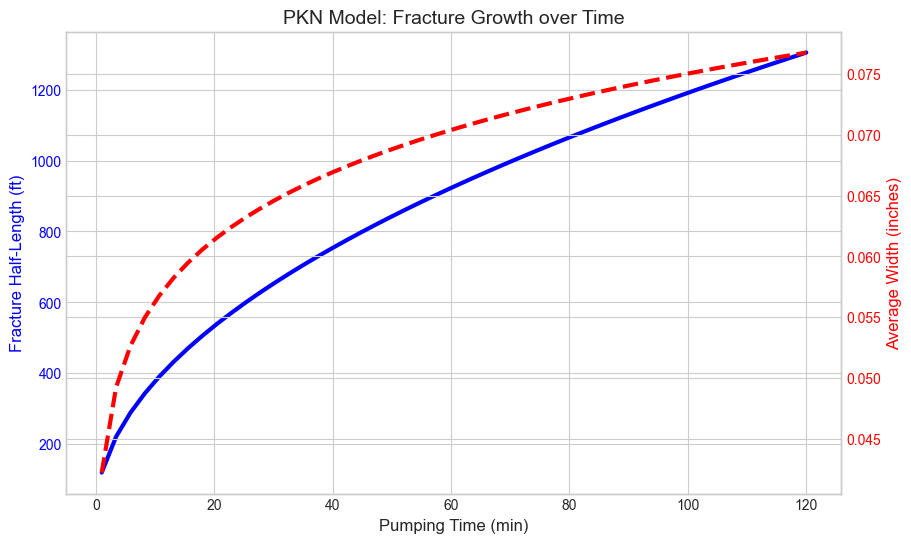

In [3]:
# Simulation Loop
time_steps = np.linspace(1, 120, 50) # 2 hours
lengths = []
widths = []

for t in time_steps:
    l, w = calc_pkn_geometry(t, job_data['q_bpm'], job_data['h_ft'], 
                             job_data['E_psi'], job_data['nu'], 
                             job_data['mu_cp'], job_data['Cl_ft_min'])
    lengths.append(l)
    widths.append(w)

# --- PLOTTING ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Length (Left Axis)
ax1.plot(time_steps, lengths, 'b-', linewidth=3, label='Half-Length ($x_f$)')
ax1.set_xlabel('Pumping Time (min)', fontsize=12)
ax1.set_ylabel('Fracture Half-Length (ft)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Plot Width (Right Axis)
ax2 = ax1.twinx()
ax2.plot(time_steps, widths, 'r--', linewidth=3, label='Avg Width ($\bar{w}$)')
ax2.set_ylabel('Average Width (inches)', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

plt.title("PKN Model: Fracture Growth over Time", fontsize=14)
plt.show()

## 3. Sensitivity: Viscosity Impact
Why do we use Gel instead of Water?
To get **Width**.

Let's compare **Slickwater (2 cp)** vs **Crosslinked Gel (200 cp)**.

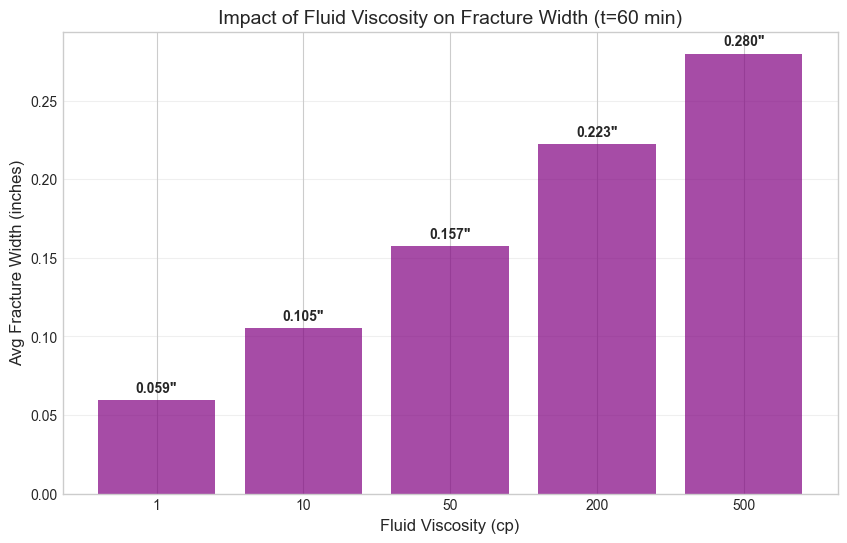

In [4]:
viscosities = [1, 10, 50, 200, 500]
results_w = []
results_l = []

for mu in viscosities:
    # Recalculate for t=60 min
    l, w = calc_pkn_geometry(60, job_data['q_bpm'], job_data['h_ft'], 
                             job_data['E_psi'], job_data['nu'], 
                             mu, job_data['Cl_ft_min'])
    results_w.append(w)
    results_l.append(l)

# Plot Width vs Viscosity
plt.figure(figsize=(10, 6))
plt.bar([str(v) for v in viscosities], results_w, color='purple', alpha=0.7)

plt.title("Impact of Fluid Viscosity on Fracture Width (t=60 min)", fontsize=14)
plt.xlabel("Fluid Viscosity (cp)", fontsize=12)
plt.ylabel("Avg Fracture Width (inches)", fontsize=12)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(results_w):
    plt.text(i, v + 0.005, f"{v:.3f}\"", ha='center', fontweight='bold')

plt.show()

## Summary
We have completed the final chapter!

**The Trade-off:**
* **Low Viscosity (Water):** Creates Long, Narrow fractures (Great for gas shale).
* **High Viscosity (Gel):** Creates Short, Wide fractures (Great for high-perm oil to place big sand).

**Project Completion:**
We now have a complete Python repository covering the reservoir lifecycle:
1.  **Fluid Props**
2.  **Inflow**
3.  **Outflow**
4.  **System/Choke**
5.  **Forecasting**
6.  **Diagnostics**
7.  **Artificial Lift**
8.  **Stimulation**